### Library Installation

In [ ]:
!pip install -qU langchain langchain_community tavily-python langchain-groq groq replicate crewai crewai[tools]
!pip install portkey-ai

### API Initialization

In [ ]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_APIKEY")
os.environ["REPLICATE_API_TOKEN"] = userdata.get("REPLICATE_API_TOKEN")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
PORTKEY_API_KEY = userdata.get("PORTKEY_API_KEY")

### Web Search Tool Helper Function

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
def web_search_tool(question: str) -> str:
    """This tool is useful when we want web search for current events."""
    websearch = TavilySearchResults()
    response = websearch.invoke({"query":question})
    return response

### Text to Image Creation Helper Function

In [ ]:
import replicate
def text2image(text:str) -> str:
    """This tool is useful when we want to generate images from textual descriptions."""
    output = replicate.run(
    "adirik/flux-cinestill:216a43b9975de9768114644bbf8cd0cba54a923c6d0f65adceaccfc9383a938f",
    input={
        "steps": 28,
        "prompt": text,
        "lora_url": "",
        "control_type": "depth",
        "control_image": "https://replicate.delivery/pbxt/LUSNInCegT0XwStCCJjXOojSBhPjpk2Pzj5VNjksiP9cER8A/ComfyUI_02172_.png",
        "lora_strength": 1,
        "output_format": "webp",
        "guidance_scale": 2.5,
        "output_quality": 100,
        "negative_prompt": "low quality, ugly, distorted, artefacts",
        "control_strength": 0.45,
        "depth_preprocessor": "DepthAnything",
        "soft_edge_preprocessor": "HED",
        "image_to_image_strength": 0,
        "return_preprocessed_image": False
        }
    )
    print(output)
    return output[0]

### Text to Image Processing Helper Function

In [ ]:
def image2text(image_url:str,prompt:str) -> str:
  """This tool is useful when we want to generate textual descriptions from images."""
  # Function
  output = replicate.run(
    "adirik/flux-cinestill:216a43b9975de9768114644bbf8cd0cba54a923c6d0f65adceaccfc9383a938f",
    input={
        "image": image_url,
        "top_p": 1,
        "prompt": prompt,
        "max_tokens": 1024,
        "temperature": 0.2
    }
  )
  return "".join(output)

### Router Tool Setup

In [ ]:
from crewai.tools import tool

@tool("router tool")
def router_tool(question:str) -> str:
  """Router Function"""
  prompt = f"""Based on the Question provide below determine the following:
    1. Is the question directed at generating image ?
    2. Is the question directed at describing the image ?
    3. Is the question a generic one and needs to be answered by searching the web?
    Question: {question}

    RESPONSE INSTRUCTIONS:
    - Answer either 1 or 2 or 3.
    - Answer should strictly be a string.
    - Do not provide any preamble or explanations except for 1 or 2 or 3.

    OUTPUT FORMAT:
    1
    """
  response = llm.invoke(prompt).content
  if response == "1":
    return 'text2image'
  elif response == "3":
    return 'web_search'
  else:
    return 'image2text'

### Retriever Tool

In [ ]:
@tool("retriver tool")
def retriver_tool(router_response:str,question:str,image_url:str) -> str:
  """Retriver Function"""
  if router_response == 'text2image':
    return text2image(question)
  elif router_response == 'image2text':
    return image2text(image_url,question)
  else:
    return web_search_tool(question)

### Portkey Setup

In [ ]:
from langchain_openai import ChatOpenAI
from portkey_ai import createHeaders, PORTKEY_GATEWAY_URL

portkey_headers = createHeaders(
        api_key = PORTKEY_API_KEY,
        virtual_key = "open-ai-virtual-07f788",
    )

llm = ChatOpenAI(api_key=PORTKEY_API_KEY, base_url=PORTKEY_GATEWAY_URL, default_headers=portkey_headers)


### Router Agent

In [ ]:
from crewai import Agent
Router_Agent = Agent(
  role = 'Router',
  goal = 'Route user question to a text to image or text to speech or web search',
  backstory = (
    "You are an expert at routing a user question to a text to image or web search."
    "Use the text to image to generate images from textual descriptions."
    "Use the image to text to generate text describing the image based on the textual description."
    "Use the web search to search for current events."
    "You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use web-search."
  ),
  verbose = True,
  allow_delegation = False,
  llm = llm,
  tools = [router_tool],
)

### Retriever Agent

In [ ]:
Retriever_Agent = Agent(
role = "Retriever",
goal = "Use the information retrieved from the Router to answer the question and image url provided.",
backstory = (
    "You are an assistant for directing tasks to respective agents based on the response from the Router."
    "Use the information from the Router to perform the respective task."
    "Do not provide any other explanation"
),
verbose = True,
allow_delegation = False,
llm = llm,
tools = [retriver_tool],
)

### Router Task

In [ ]:
from crewai import Task
router_task = Task(
    description=("Analyse the keywords in the question {question}"
    "If the question {question} instructs to describe a image then use the image url {image_url} to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question {question}."
    "Based on the keywords decide whether it is eligible for a text to image or text to speech or web search."
    "Return a single word 'text2image' if it is eligible for generating images from textual description."
    "Return a single word 'image2text' if it is eligible for describing the image based on the question {question} and image url{image_url}."
    "Return a single word 'web_search' if it is eligible for web search."
    "Do not provide any other explaination."
    ),
    expected_output=("Give a choice 'web_search' or 'text2image' or 'image2text' based on the question {question} and image url {image_url}"
    "Do not provide any preamble or explanations except for 'text2image' or 'web_search' or 'image2text'."),
    agent=Router_Agent,
)


### Retriever Task

In [ ]:
retriever_task = Task(
    description=("Based on the response from the 'router_task' generate response for the question {question} with the help of the respective tool."
    "Use the web_serach_tool to retrieve information from the web in case the router task output is 'web_search'."
    "Use the text2image tool to convert the test to speech in English in case the router task output is 'text2image'."
    "Use the image2text tool to describe the image provide in the image url in case the router task output is 'image2text'."
    ),
    expected_output=("You should analyse the output of the 'router_task'"
    "If the response is 'web_search' then use the web_search_tool to retrieve information from the web."
    "If the response is 'text2image' then use the text2image tool to generate a detailed and high quality images covering all the nuances secribed in the textual descriptions provided in the question {question}."
    "If the response is 'image2text' then use the 'image2text' tool to describe the image based on the question {question} and {image_url}."
    ),
    agent=Retriever_Agent,
    context=[router_task],
)


### Crew Setup and Initiation

In [ ]:
from crewai import Crew,Process
crew = Crew(
    agents=[Router_Agent,Retriever_Agent],
    tasks=[router_task,retriever_task],
    verbose=True,
)

inputs = {
  "question": "Generate an image based upon this text: a cinematic portrait of a majestic black panther, piercing yellow eyes, moody lighting, soft bokeh, 85mm lens, deep blue jungle background",
  "image_url": " "
}

result = crew.kickoff(inputs=inputs)

 
[2025-03-10 07:21:25][🚀 CREW 'CREW' STARTED, FEB51674-09FE-48B9-8C87-640C51837B9F]: 2025-03-10 07:21:25.580462
 
[2025-03-10 07:21:25][📋 TASK STARTED: ANALYSE THE KEYWORDS IN THE QUESTION GENERATE AN IMAGE BASED UPON THIS TEXT: A CINEMATIC PORTRAIT OF A MAJESTIC BLACK PANTHER, PIERCING YELLOW EYES, MOODY LIGHTING, SOFT BOKEH, 85MM LENS, DEEP BLUE JUNGLE BACKGROUNDIF THE QUESTION GENERATE AN IMAGE BASED UPON THIS TEXT: A CINEMATIC PORTRAIT OF A MAJESTIC BLACK PANTHER, PIERCING YELLOW EYES, MOODY LIGHTING, SOFT BOKEH, 85MM LENS, DEEP BLUE JUNGLE BACKGROUND INSTRUCTS TO DESCRIBE A IMAGE THEN USE THE IMAGE URL   TO GENERATE A DETAILED AND HIGH QUALITY IMAGES COVERING ALL THE NUANCES SECRIBED IN THE TEXTUAL DESCRIPTIONS PROVIDED IN THE QUESTION GENERATE AN IMAGE BASED UPON THIS TEXT: A CINEMATIC PORTRAIT OF A MAJESTIC BLACK PANTHER, PIERCING YELLOW EYES, MOODY LIGHTING, SOFT BOKEH, 85MM LENS, DEEP BLUE JUNGLE BACKGROUND.BASED ON THE KEYWORDS DECIDE WHETHER IT IS ELIGIBLE FOR A TEXT TO IMA

### Agent Output -- Image Link

In [ ]:
result.raw

'https://replicate.delivery/xezq/wosCFPhSTe10ViOHi0zBw1LqE7pOWdbeMxE4VEEmKwXBUEXUA/out-0.webp'

### Printing Image

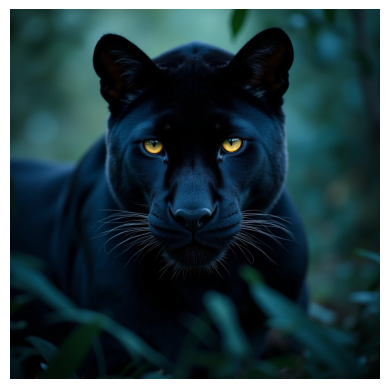

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# URL of the image
image_url = result.raw

# Fetch the image
response = requests.get(image_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image using PIL
    img = Image.open(BytesIO(response.content))

    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()
else:
    print("Failed to retrieve image. Status code:", response.status_code)